In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from IPython.display import display
from matplotlib.patches import Rectangle

from experiments.pw_exp import (
    TransitionType,
    NumGTModes,
    ExperimentConfig
) 


In [2]:

def mean_ci(values, confidence_level=0.9):
    """Compute mean and symmetric confidence interval for a list of values
    
    Args:
        values (list): List of float
        confidence_level (float): Confidence level
    
    Returns:
        (float): Lower confidence interval
        (float): Mean value
        (float): Upper confidence interval
    """
    mean = np.mean(values)
    std = np.std(values)
    num_repeats = len(values)
    
    # Compute Z-factor
    critical_value = 1.0 - confidence_level
    z_factor = norm().ppf(1 - critical_value / 2)
    
    # Compute CI
    ci = z_factor * std / np.sqrt(num_repeats)
    
    return mean - ci, mean, mean + ci
    

def plot_suite(df, metric_values, confidence_level=0.9):
    
    # Hue and line stype is initialization method
    # Marker style is number of learned modes
    # Plot number of demonstrations on X axis
    # Plot NID on y-axis
    # For each datapoint, plot mean and 90% confidence interval
    # Connect datapoints with linear lines
    
    
    
    possible_metric_values = [
        "Iterations",
        "Runtime",
        "NLL",
        "NID",
        "aNID",
        "MCFEVD",
        "MEVD"
        "MCFILE",
        "MILE"
    ]
    
    for metric_str in metric_values:
        assert metric_str in possible_metric_values
    
    init_method_values = sorted(df["Initialisation"].unique(), reverse=True)
    num_learned_modes_values = sorted(df["Num Learned Clusters"].unique().astype(int))
    num_rollouts_values = sorted(df["Num Rollouts"].unique())
    
    sns.set_context('poster')
    fig, axes = plt.subplots(
        len(num_learned_modes_values),
        len(metric_values),
        sharex=True,
        figsize=(7 * len(metric_values), 6 * len(num_learned_modes_values)),
        dpi=300,
        gridspec_kw=dict(wspace=0.15, hspace=0.1)
    )
    
    # Sweep different metrics (horizontal plot identity)
    for metric_idx, metric in enumerate(metric_values):
        
        # Sweep number learned modes (y plot location)
        for learned_modes_idx, num_learned_modes in enumerate(num_learned_modes_values):

            plt.sca(axes[learned_modes_idx][metric_idx])

            # Sweep initialization methods
            for init_idx, init_method in enumerate(init_method_values):
                color_str = f"C{init_idx}"
                line_style = ['-', '--', ':'][init_idx]
                legend_str = {
                    "uniform": 'Uniform',
                    "kmeans": 'K-Means',
                    "gmm": 'GMM',
                }[init_method]
                marker_style = ['o', '^', 'D'][init_idx]
                
                # Sweep number of rollouts (x-axis)
                x = []
                y = []
                yerr = []
                y_test = []
                yerr_test = []
                for num_rollouts in num_rollouts_values:
                    
                    # Slice this experiment
                    exp = df.query("""
                    `Initialisation` == @init_method &"""
                    """`Num Learned Clusters` == @num_learned_modes &"""
                    """`Num Rollouts` == @num_rollouts
                    """)
                    x.append(num_rollouts)
                    
                    # Print title for this plot? (only for first row)
                    if metric == "Iterations":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Iterations"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Iterations"
                        #_, ymax = plt.ylim()
                        #ymin = -1
                        #plt.ylim(ymin, ymax)
                        
                    elif metric == "Runtime":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Runtime (s)"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        plt.semilogy()
                        
                        title_str = "$\log_{10}$ Runtime in seconds"
                        
                    elif metric == "NLL":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Negative Log Likelihood (Train Set)"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        ylow_test, ybar_test, yhigh_test = mean_ci(exp["Negative Log Likelihood (Test Set)"], confidence_level=confidence_level)
                        y_test.append(ybar_test)
                        yerr_test.append(yhigh_test - ybar_test)
                        
                        title_str = "Negative Log Likelihood"
                        
                    elif metric == "NID":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Normalized Information Distance (Train Set)"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        ylow_test, ybar_test, yhigh_test = mean_ci(exp["Normalized Information Distance (Test Set)"], confidence_level=confidence_level)
                        y_test.append(ybar_test)
                        yerr_test.append(yhigh_test - ybar_test)
                        
                        title_str = "Normalized Information Distance"
                        plt.ylim(-0.05, 1.05)
                        
                    elif metric == "aNID":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Adjusted Normalized Information Distance (Train Set)"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        ylow_test, ybar_test, yhigh_test = mean_ci(exp["Adjusted Normalized Information Distance (Test Set)"], confidence_level=confidence_level)
                        y_test.append(ybar_test)
                        yerr_test.append(yhigh_test - ybar_test)
                        
                        title_str = "Normalized Information Distance\n(Adjusted for chance)"
                        plt.ylim(-0.05, 1.05)
                        
                    elif metric == "MCFILE":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Min Cost Flow ILE"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Min Cost Flow\nInverse Learning Error"
                        
                    elif metric == "MILE":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Mean ILE"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Mean Inverse Learning Error"
                        
                    elif metric == "MCFEVD":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Min Cost Flow EVD"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Min Cost Flow\nExpected Value Difference"
                        
                    elif metric == "MILE":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Mean EVD"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Mean Expected Value Difference"
                        
                    else:
                        raise ValueError
                    
                    if learned_modes_idx == 0:
                        plt.title(title_str, pad=10)
                
                x = np.array(x)
                y = np.array(y)
                yerr = np.array(yerr)
                
                plt.plot(
                    x,
                    y,
                    color=color_str,
                    label=legend_str,
                    marker=marker_style
                )
                plt.fill_between(
                    x,
                    y - yerr,
                    y + yerr,
                    color=color_str,
                    alpha=0.2
                )
                
                if len(y_test) > 0:
                    # Plot testing curves as dashed lines
                    
                    y_test = np.array(y_test)
                    yerr_test = np.array(yerr_test)

                    plt.plot(
                        x,
                        y_test,
                        color=color_str,
                        label=f"{legend_str} (test)",
                        marker=marker_style,
                        linestyle='--'
                    )
                    plt.fill_between(
                        x,
                        y_test - yerr_test,
                        y_test + yerr_test,
                        color=color_str,
                        alpha=0.2,
                        linestyle='--'
                    )
                    
                
                plt.xticks(x)
                if learned_modes_idx == len(num_learned_modes_values) - 1:
                    plt.xlabel("Number of demonstrations")
                
                if metric_idx == 0:
                    row_label = f"{num_learned_modes} learned mode{'s' if num_learned_modes > 1 else ''}"
                    if num_learned_modes < exp["Num GT Clusters"].unique()[0]:
                        row_label += "\n(under-clustering)"
                    elif num_learned_modes > exp["Num GT Clusters"].unique()[0]:
                        row_label += "\n(over-clustering)"
                    else:
                        row_label += "\n(matches GT)"
                    plt.ylabel(row_label, labelpad=10)
            
            plt.gca().yaxis.tick_right()
            plt.tick_params(axis='y', length=0)
    
    return fig, axes


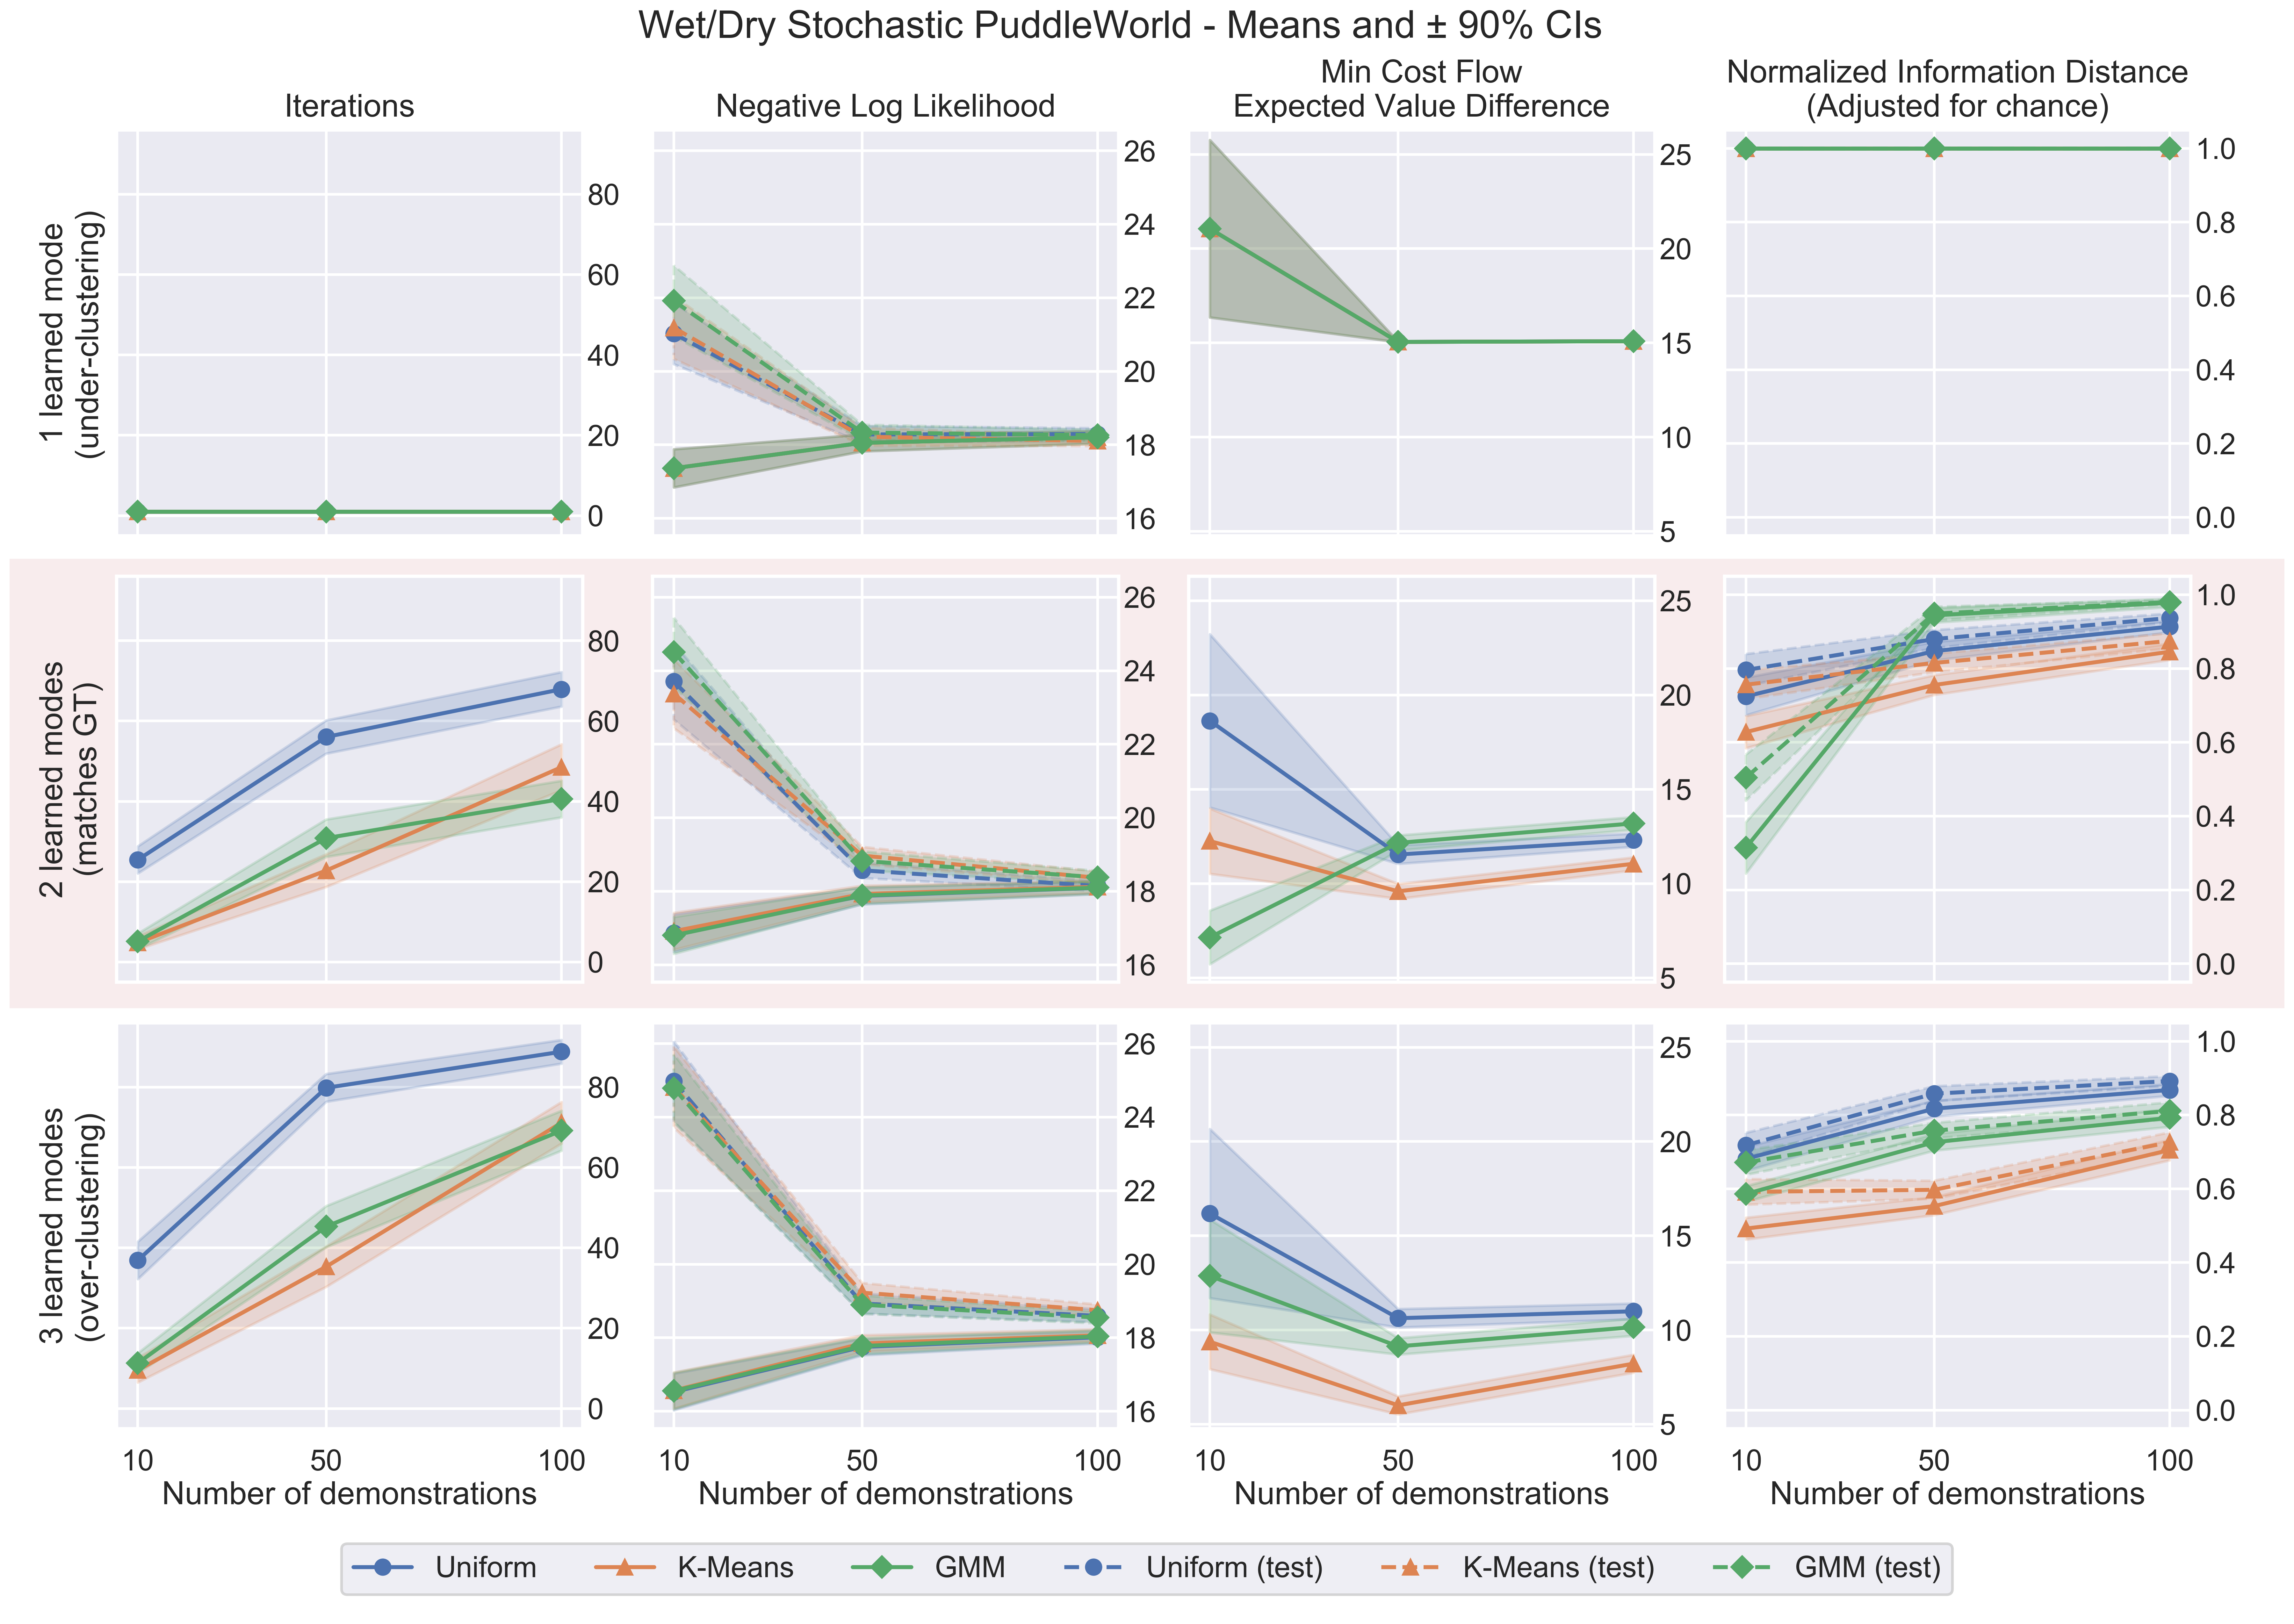

In [21]:

# Load the experimental static inputs
config = ExperimentConfig(TransitionType.STOCHASTIC, NumGTModes.TWO)

# Load the experimental results
df_filename = f"CanonicalPuddleWorld-{config.transition_type.value}-{config.num_gt_modes.value}mode-experiments-metrics.csv"
df = pd.read_csv(df_filename)

confidence_level = 0.90

sns.set()
fig, axes = plot_suite(df, ["Iterations", "NLL", "MCFEVD", "aNID"], confidence_level=confidence_level)

# Make y-limits for each column of plots consistent
for column in range(len(axes[0])):
    
    ymin = np.inf
    ymax = -np.inf
    
    for row in range(len(axes)):
        ax = axes[row][column]
        _ymin, _ymax = ax.get_ylim()
        ymin = min(ymin, _ymin)
        ymax = max(ymax, _ymax)
    
    for row in range(len(axes)):
        ax = axes[row][column]
        ax.set_ylim(ymin, ymax)

# Adjust ylimits for certain columns
for ax_row in axes:
    if config.transition_type == TransitionType.STOCHASTIC and config.num_gt_modes == NumGTModes.THREE:
        ymin, ymax = ax_row[0].get_ylim()
        ax_row[0].set_ylim(-5, ymax)
        
        ymin, ymax = ax_row[2].get_ylim()
        ax_row[2].set_ylim(ymin, 10.3)
        
    if config.transition_type == TransitionType.STOCHASTIC and config.num_gt_modes == NumGTModes.TWO:
        ymin, ymax = ax_row[0].get_ylim()
        ax_row[0].set_ylim(-5, ymax)
        
    if config.transition_type == TransitionType.DETERMINISTIC and config.num_gt_modes == NumGTModes.THREE:        
        ymin, ymax = ax_row[2].get_ylim()
        ax_row[2].set_ylim(-5, ymax)
        
    if config.transition_type == TransitionType.DETERMINISTIC and config.num_gt_modes == NumGTModes.TWO:        
        ymin, ymax = ax_row[2].get_ylim()
        ax_row[2].set_ylim(-10, ymax)

# Produce legend, in a particular order
handles, labels = plt.gca().get_legend_handles_labels()
legend_axes_pad = 3 if (config.num_gt_modes == NumGTModes.THREE) else 1
order = [0, 2, 4, 1, 3, 5]
fig.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    ncol=6,
    loc='lower center',
    borderaxespad=legend_axes_pad
)

# Add title
mode_names = "/".join([s.capitalize() for s in NumGTModes.get_mode_names(config.num_gt_modes)])
plt.suptitle(
    f"{mode_names} {config.transition_type.value.capitalize()} PuddleWorld - Means and ± {int(confidence_level * 100)}% CIs",
    y=0.93 if config.num_gt_modes == NumGTModes.THREE else 0.95
)

# Highlight the middle row where learned number of modes == GT number of modes
rect_pad = 0.03
if config.num_gt_modes == NumGTModes.TWO:
    rect = Rectangle(
        (
            0.085,
            1.0 / 3.0 + rect_pad * 1.2
        ),
        0.85,
        1.0 / 3.0 - rect_pad * 2.4,
        linewidth=0,
        facecolor='r',
        alpha=0.1,
        zorder=-1
    )
else:
    rect = Rectangle(
        (
            0.085,
            2.0 / 5.0 + rect_pad * 0.85
        ),
        0.85,
        1.0 / 5.0 - rect_pad * 1.5,
        linewidth=0,
        facecolor='r',
        alpha=0.1,
        zorder=-1
    )
fig.add_artist(rect)

plt.savefig(df_filename.replace(".csv", ".pdf"), bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()
